In [39]:
import numpy as np
import cv2

In [40]:
# PSO Parameters
SWARM_SIZE = 30    # Number of particles
DIMENSIONS = 3    # Number of thresholds (for example, 3 thresholds for 4 classes)
MAX_ITERATIONS = 1  # Maximum number of iterations
W = 0.5    # Inertia weight
C1 = 1.5   # Cognitive coefficient
C2 = 1.5   # Social coefficient
RANGE = 256  # Range for initializing particle positions (pixel intensity range)

In [41]:
# Objective function to minimize (Otsu's between-class variance)
def otsu_objective_function(thresholds, image_histogram, total_pixels):
    thresholds = np.sort(thresholds).astype(int)  # Sort and convert thresholds to integers
    thresholds = np.concatenate(([0], thresholds, [255]))  # Add 0 and 255 as boundaries
    between_class_variance = 0
    global_mean = np.sum(np.arange(256) * image_histogram) / total_pixels  # Overall mean of the image
    
    for i in range(1, len(thresholds)):
        class_range = image_histogram[thresholds[i-1]:thresholds[i]]
        class_pixels = np.sum(class_range)
        
        if class_pixels == 0:
            continue
        
        p_class = class_pixels / total_pixels  # Class probability
        mean_class = np.sum(np.arange(thresholds[i-1], thresholds[i]) * class_range) / class_pixels
        between_class_variance += p_class * (mean_class - global_mean) ** 2
    
    return -between_class_variance if between_class_variance > 0 else np.inf



In [42]:
def pso_algorithm(image_histogram, total_pixels):
    swarm = np.random.uniform(0, RANGE, (SWARM_SIZE, DIMENSIONS))  # Initialize particle positions
    velocities = np.random.uniform(-RANGE, RANGE, (SWARM_SIZE, DIMENSIONS))  # Initialize particle velocities
    personal_best_positions = np.copy(swarm)
    personal_best_values = np.apply_along_axis(otsu_objective_function, 1, swarm, image_histogram, total_pixels)
    
    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index]
    global_best_value = personal_best_values[global_best_index]
    
    for t in range(MAX_ITERATIONS):
        print(f"\nIteration {t+1}")
        print("  Local Best Positions and Values:")
        # Update velocities and positions
        r1, r2 = np.random.rand(SWARM_SIZE, DIMENSIONS), np.random.rand(SWARM_SIZE, DIMENSIONS)
        velocities = (W * velocities +
                      C1 * r1 * (personal_best_positions - swarm) +
                      C2 * r2 * (global_best_position - swarm))
        swarm += velocities
        swarm = np.clip(swarm, 0, RANGE)  # Ensure thresholds are within the valid range
        
        fitness_values = np.apply_along_axis(otsu_objective_function, 1, swarm, image_histogram, total_pixels)
        
        # Update personal bests
        for i in range(SWARM_SIZE):
            if fitness_values[i] < personal_best_values[i]:
                personal_best_positions[i] = swarm[i]
                personal_best_values[i] = fitness_values[i]
            
            print(f"    Particle {i}: Position {personal_best_positions[i]}, Value {personal_best_values[i]}")

        # Update global best
        current_best_index = np.argmin(personal_best_values)
        current_best_value = personal_best_values[current_best_index]
        if current_best_value < global_best_value:
            global_best_position = personal_best_positions[current_best_index]
            global_best_value = current_best_value
        
        print(f"  Global Best Position and Value:")
        print(f"    Global Best Position: {global_best_position}, Global Best Value: {global_best_value}")

    return global_best_position, global_best_value

In [43]:
def apply_thresholds(image, thresholds):
    thresholds = np.sort(thresholds).astype(int)
    segmented_image = np.zeros_like(image)
    
    # Apply thresholds to create segmented image
    segmented_image[image <= thresholds[0]] = 0
    for i in range(1, len(thresholds)):
        segmented_image[(image > thresholds[i-1]) & (image <= thresholds[i])] = i
    segmented_image[image > thresholds[-1]] = len(thresholds)
    
    return segmented_image


In [44]:

if __name__ == "__main__":
    # Load grayscale image and calculate histogram
    image = cv2.imread('dataset/2.BMP', 0)  # Load image in grayscale
    image_histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()  # Compute histogram
    total_pixels = image.size  # Total number of pixels

    # Run PSO for multi-level Otsu thresholding
    best_position, best_value = pso_algorithm(image_histogram, total_pixels)
    print("\nFinal Best Position (Thresholds):", np.sort(best_position))
    print("Final Best Value (Between-class variance):", best_value)



Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [ 27.06884735  86.15481419 219.85610654], Value -410.41688395277185
    Particle 1: Position [184.57233244 148.55694798  69.71509373], Value -1309.490728558378
    Particle 2: Position [170.44413894 238.2589835    0.        ], Value -964.5226034878804
    Particle 3: Position [ 30.56748899 115.93014503 144.63544279], Value -1237.5886914148573
    Particle 4: Position [148.8970232   90.16472968 219.51449854], Value -1285.4091132290175
    Particle 5: Position [240.14093453 144.12735141  99.9381594 ], Value -1272.2042723690004
    Particle 6: Position [256.         215.74986515 150.95374877], Value -1119.185517680585
    Particle 7: Position [225.29263383   0.74045279 119.92985007], Value -1007.598046046349
    Particle 8: Position [ 99.3584598  126.93443817 131.18211195], Value -1232.2612044045902
    Particle 9: Position [240.45818543 116.68746036 175.1389181 ], Value -1219.5472780242358
    Particle 10: Position 

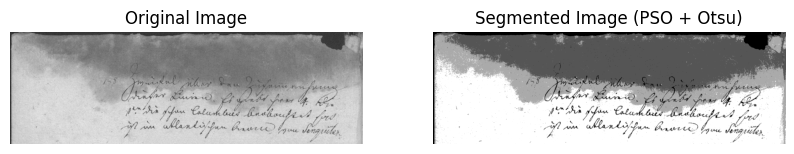

In [45]:
import matplotlib.pyplot as plt
# Apply the optimal thresholds to the image
segmented_image = apply_thresholds(image, best_position)
    
    # Plot the original image and the segmented image
plt.figure(figsize=(10, 5))
    
    # Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')
    
    # Segmented image
plt.subplot(1, 2, 2)
plt.title('Segmented Image (PSO + Otsu)')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
    
plt.show()


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [  0.         132.4208486  156.23833618], Value -2942.040332689319
    Particle 1: Position [ 59.27606516 171.45746045 256.        ], Value -3033.4587015385937
    Particle 2: Position [ 45.37907022 190.62473086 128.53372163], Value -3092.557847997779
    Particle 3: Position [ 72.42346601 130.99997143  25.77732242], Value -2962.2315461913136
    Particle 4: Position [153.65262259 256.         256.        ], Value -2798.8053118509483
    Particle 5: Position [110.986458   220.93098005 133.06706849], Value -2966.2680316570054
    Particle 6: Position [ 64.05625327 156.43108405 199.83993087], Value -3119.9451022719104
    Particle 7: Position [123.40538941  12.85314087 177.51517832], Value -3023.612673018158
    Particle 8: Position [  7.09366361  97.51138764 244.03251937], Value -2773.2093209091204
    Particle 9: Position [241.31908098  62.84167922 168.79817409], Value -3045.263102268202
    Particle 10: Position 

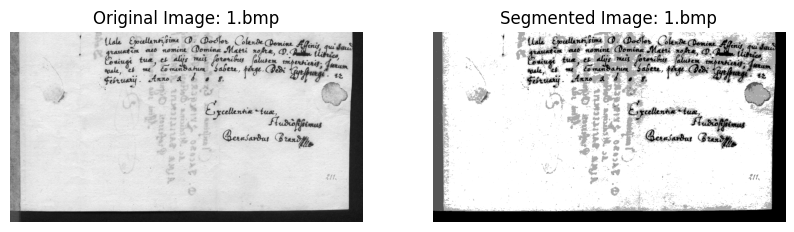


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [  7.89928479 127.4244175  185.35308844], Value -356.85833384497676
    Particle 1: Position [  0.        109.411378  159.6041966], Value -282.09529131880356
    Particle 2: Position [102.08213155 122.93439443 166.79373483], Value -325.4707320594917
    Particle 3: Position [173.35294757 174.49100652 236.80449258], Value -253.49318883976966
    Particle 4: Position [218.6554027  204.58378757 166.86521024], Value -272.57076015178217
    Particle 5: Position [132.4374347  212.16380503 207.45939289], Value -216.40816972163378
    Particle 6: Position [161.2001855  163.92130044 223.98353414], Value -233.30744854728707
    Particle 7: Position [ 39.41493585 207.58147559 146.42687948], Value -213.3796461509752
    Particle 8: Position [100.88406329  51.45574063 240.17631537], Value -172.61418268596105
    Particle 9: Position [ 16.95311835 145.78671141 165.76759874], Value -298.6069297777978
    Particle 10: Position [ 

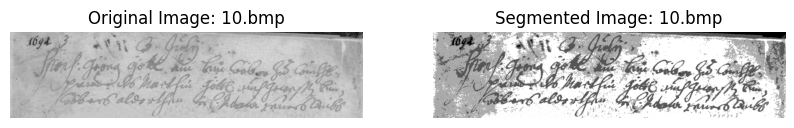


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [ 18.22524368 137.88901215 169.19986363], Value -1246.7673390141
    Particle 1: Position [  0.         162.62855489 149.04026203], Value -1168.3885871458228
    Particle 2: Position [ 55.26068404 175.09392656  76.01341942], Value -1090.327349086052
    Particle 3: Position [160.53144134  32.83573873 188.34484796], Value -1072.854035284515
    Particle 4: Position [149.70943154 216.76875002  62.11432759], Value -1258.8986357845884
    Particle 5: Position [ 73.16189582  71.99951826 256.        ], Value -374.9027482586951
    Particle 6: Position [134.402029   117.94198092 125.65478891], Value -1181.5378595747084
    Particle 7: Position [159.57923055 189.52560629   6.11812415], Value -1074.0365870806331
    Particle 8: Position [  2.83511297 229.60708785 104.54553626], Value -592.7381060942504
    Particle 9: Position [249.67037435 238.4252494  141.53071014], Value -1138.9882862282534
    Particle 10: Position [ 7

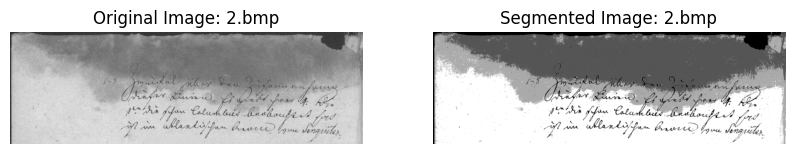


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [148.78946989  38.75403291 101.34625036], Value -1288.3346196597302
    Particle 1: Position [ 54.76319534  22.21807584 118.44473715], Value -1081.1016064849614
    Particle 2: Position [128.00599677 169.50205016 141.71522953], Value -1283.3872318694603
    Particle 3: Position [ 32.94457998 152.28050238 194.69553219], Value -1322.6043159698947
    Particle 4: Position [140.82481808 126.43851996 171.25197992], Value -1291.0721854370047
    Particle 5: Position [  4.16481866 114.63011607  34.40841205], Value -1025.91888217818
    Particle 6: Position [ 73.28048558  65.61995056 124.19951364], Value -1143.4547472414017
    Particle 7: Position [176.23553197 225.82794955 134.86624872], Value -1277.6538328466572
    Particle 8: Position [  0.         122.70304242 176.11855939], Value -1286.3082347490017
    Particle 9: Position [  0.         226.18415987 154.77143553], Value -1169.426018853027
    Particle 10: Position

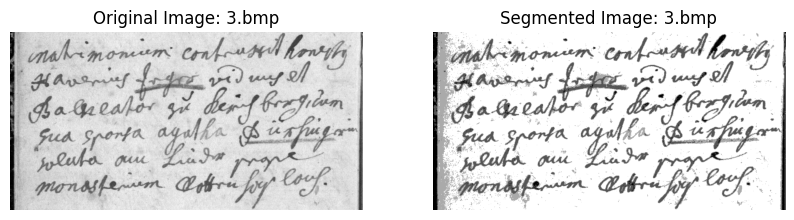


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [ 62.53670494 152.53410162 135.48082526], Value -2522.4987132411397
    Particle 1: Position [116.71168334 181.35998234 153.94436619], Value -2558.4323303377328
    Particle 2: Position [248.44705479  68.20968694 256.        ], Value -2008.687877534161
    Particle 3: Position [ 57.99350733 200.90472454 256.        ], Value -2112.8299244379427
    Particle 4: Position [129.61015961 173.69051514 239.69564937], Value -2420.34276366111
    Particle 5: Position [ 37.43459386 125.11984685 207.57824429], Value -2484.7561000335545
    Particle 6: Position [ 93.71078517  45.68872499 160.32327276], Value -2577.5657407603994
    Particle 7: Position [191.94474802 222.00760187  86.35642679], Value -2462.1613959833467
    Particle 8: Position [218.62567439 212.23188007 155.75269954], Value -2142.848961866042
    Particle 9: Position [  0.         114.58323744 182.10801126], Value -2503.507063728609
    Particle 10: Position [

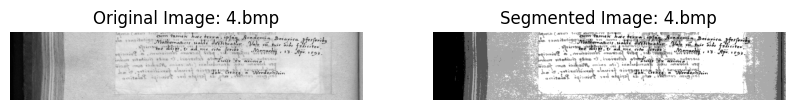


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [ 29.74134654 133.15627789 173.29717542], Value -1174.0765462358152
    Particle 1: Position [ 66.47465694 142.63590191 176.62565612], Value -1174.1718062154878
    Particle 2: Position [162.3259152  242.52529073  97.95983984], Value -1131.0415976871582
    Particle 3: Position [  0.         204.15013597 151.97766988], Value -1139.421435073956
    Particle 4: Position [ 16.67658086 236.67938501 174.00787562], Value -1055.372685485549
    Particle 5: Position [ 71.97660375 175.13923365 167.90755228], Value -1110.8461780768696
    Particle 6: Position [ 86.18918197 216.99574565 167.56642257], Value -1128.2343332548373
    Particle 7: Position [125.15323557 212.89388893 174.01611669], Value -1203.0145060993148
    Particle 8: Position [155.777185    45.62505757 106.58589627], Value -1120.3235602941954
    Particle 9: Position [162.42850105  76.32580976  71.95388384], Value -1092.9393356074263
    Particle 10: Positio

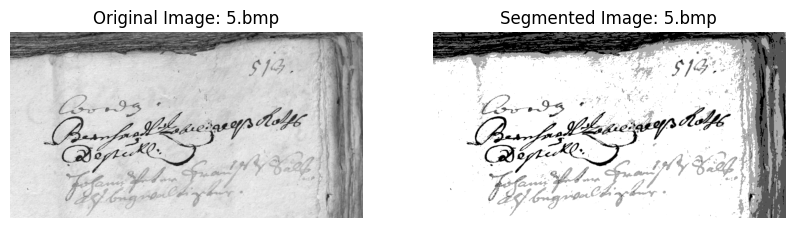


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [212.98295206   9.30623238  88.64206285], Value -2867.2374352169936
    Particle 1: Position [124.69651868 216.83665855 219.42254783], Value -2931.6706487819297
    Particle 2: Position [137.01847264 207.04660048 221.45930776], Value -2982.881719564279
    Particle 3: Position [193.82350544 139.16274572  93.84852349], Value -3141.4303840298094
    Particle 4: Position [  8.1209029   31.18657582 191.74769366], Value -2286.1513441355864
    Particle 5: Position [251.21031386 172.11014544 252.67773728], Value -2338.866909202128
    Particle 6: Position [104.05899558 183.05220028 103.8769268 ], Value -3023.1004722372604
    Particle 7: Position [108.30139084 158.59962764  83.7714182 ], Value -2922.6661121758902
    Particle 8: Position [117.70612502  38.84624451 175.5756703 ], Value -3027.500850150464
    Particle 9: Position [190.46937753  33.23966717 106.91000902], Value -3059.733666249457
    Particle 10: Position 

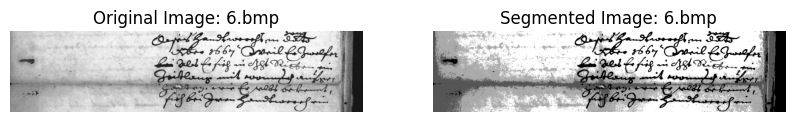


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [175.75544828  63.45050885  85.8212166 ], Value -520.0302740055225
    Particle 1: Position [133.00262821 256.         214.26442505], Value -577.9794230214734
    Particle 2: Position [156.53554415  79.67183579 235.24862859], Value -511.5453915505826
    Particle 3: Position [125.91483209 170.80457071  52.65285568], Value -520.0007726034397
    Particle 4: Position [256.         103.16592454 253.92164957], Value -389.5224591811032
    Particle 5: Position [238.45348715 155.36157585 256.        ], Value -472.23897639544685
    Particle 6: Position [214.32433271   2.7334539   74.49309346], Value -465.72759258184
    Particle 7: Position [256.         122.89320087 193.44508812], Value -554.2574233613711
    Particle 8: Position [161.68203708 169.42828345 256.        ], Value -478.65077042713995
    Particle 9: Position [100.26160144  23.10843912  62.14279585], Value -382.3781611728303
    Particle 10: Position [251.7

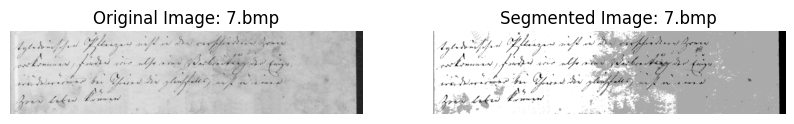


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [ 70.25121765 177.56233529 118.66419328], Value -1317.1049031520588
    Particle 1: Position [245.45231081  88.45865325  64.04319161], Value -764.4025271814961
    Particle 2: Position [205.67441169  81.0919779  185.92444239], Value -1164.4540200596537
    Particle 3: Position [ 34.33053711 135.03423172 168.98978779], Value -1254.9034979981539
    Particle 4: Position [165.54381296 256.          45.20665553], Value -1124.4490214958632
    Particle 5: Position [245.54897618 182.93842272 218.51147066], Value -837.3312483951908
    Particle 6: Position [131.37263685 150.50948953  93.26768295], Value -1240.2054688696626
    Particle 7: Position [ 26.63568988 256.         159.92598761], Value -1100.5993181907913
    Particle 8: Position [ 74.36229496  88.75806368 209.1284426 ], Value -870.2549448942589
    Particle 9: Position [118.0506022  194.91450127  70.46794095], Value -1279.4187182634896
    Particle 10: Position

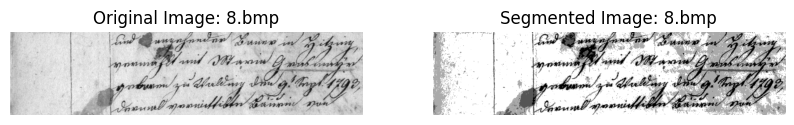


Iteration 1
  Local Best Positions and Values:
    Particle 0: Position [143.81301611   8.77473588   4.73076876], Value -2531.878396215904
    Particle 1: Position [ 45.60553336 199.30445328 122.17466034], Value -2904.9989064498272
    Particle 2: Position [108.00549371  92.84278582 125.53965902], Value -2939.848220495603
    Particle 3: Position [ 43.31178024 197.98042181 132.92030094], Value -2881.067868438974
    Particle 4: Position [241.2514517    2.59095241 119.3902518 ], Value -2796.6695118460466
    Particle 5: Position [ 24.79660422 209.04419861 128.20975088], Value -2764.3736506679006
    Particle 6: Position [187.47511957   7.13500342 139.06668343], Value -2629.302601597153
    Particle 7: Position [133.86117973  68.03558137 137.76789441], Value -2986.341871004907
    Particle 8: Position [ 53.0860278  167.18818386 107.46913656], Value -3030.0174079221088
    Particle 9: Position [157.9650435  182.37289089  69.05772348], Value -3004.3934971238314
    Particle 10: Position [

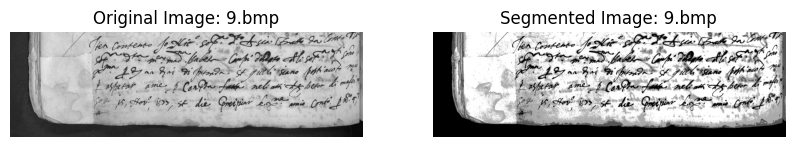

In [47]:
import os
# Process all images in a folder
def process_images_from_folder(input_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".bmp"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, 0)  # Load image in grayscale
            
            if image is None:
                print(f"Could not read {filename}. Skipping.")
                continue
            
            # Compute image histogram
            image_histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()
            total_pixels = image.size
            
            # Run PSO for multi-level Otsu thresholding
            best_position, best_value = pso_algorithm(image_histogram, total_pixels)
            print(f"Processing {filename}")
            print(f"Best Thresholds: {np.sort(best_position)}")
            print(f"Best Value: {best_value}")
            
            # Apply thresholds to the image
            segmented_image = apply_thresholds(image, best_position)
            
            # Plot the original and segmented images side by side
            plt.figure(figsize=(10, 5))
            
            # Original image
            plt.subplot(1, 2, 1)
            plt.title(f'Original Image: {filename}')
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
            # Segmented image
            plt.subplot(1, 2, 2)
            plt.title(f'Segmented Image: {filename}')
            plt.imshow(segmented_image, cmap='gray')
            plt.axis('off')
            
            # Display the plot
            plt.show()

if __name__ == "__main__":
    input_folder = "dataset"  # Folder containing the images
    process_images_from_folder(input_folder)